# Домашнее задание 5. Линейные модели

In [55]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [56]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [57]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex], ignore_index = True)

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [58]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [59]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x442764) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

(442764,)


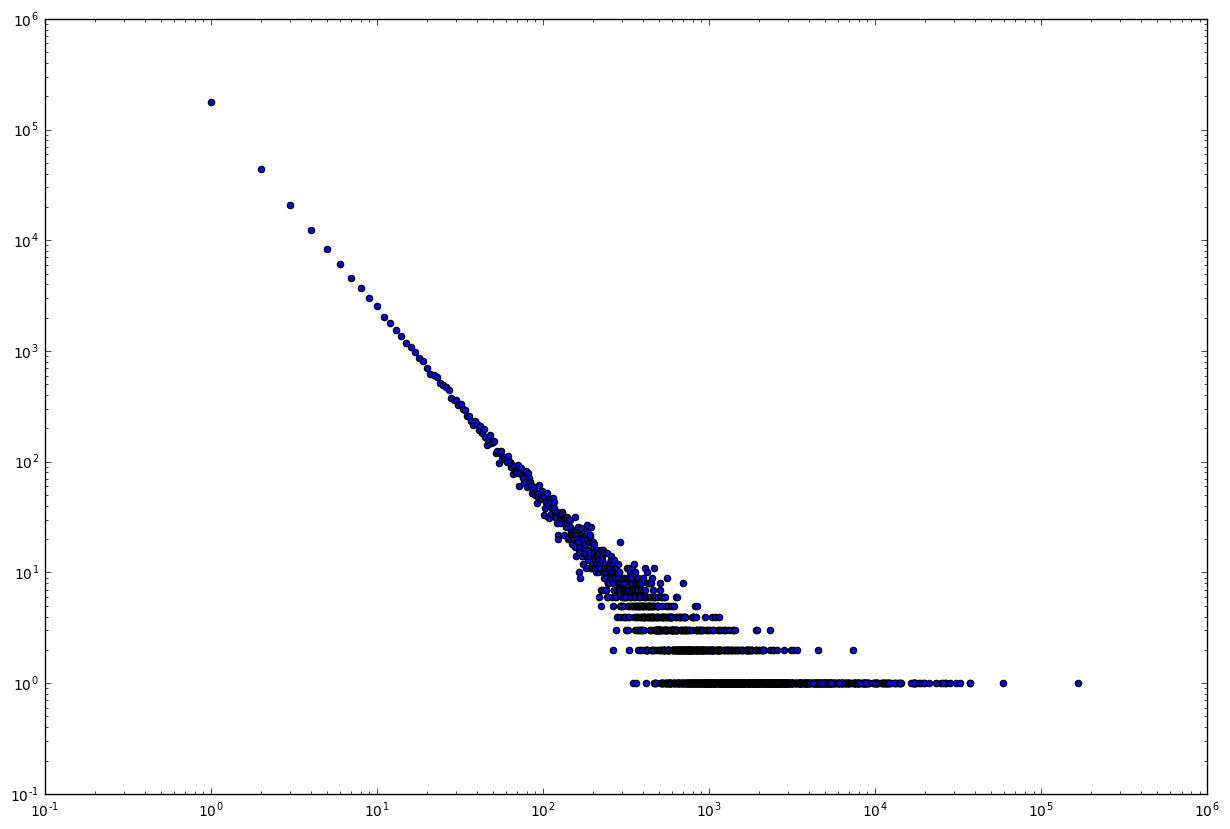

In [60]:
def draw_log_hist(X):
    """Draw tokens histogram in log scales"""
    x = []
    y = []
    token_count = np.array(X.sum(0))[0]
    token_count = np.sort(token_count)
    using_count = {}
    for i in token_count:
        cur = using_count.get(i,None)
        if (cur is None):
            using_count.update({i : 1})
        else:
            using_count.update({i : cur + 1})
    using_count.pop(0.0)      
    for i in using_count.keys():
        y.append(using_count.get(i))
        x.append(i)
    plt.figure(figsize=(15,10))
    plt.xscale("log")
    plt.yscale("log")
    pl.scatter(x,y)
    token_count = np.array(X.sign().sum(0))[0]
    return token_count

features_counts = draw_log_hist(X)
print features_counts.shape

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [74]:
X1 = X.tocsc()[:, features_counts > 100].toarray()
print X1.shape

(7199, 4859)


Вариант задания генерируется на основании вашего ника в техносфере.

In [65]:
USER_NAME = "a.sinyukov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [75]:
class LogisticRegression():
    
    def sigmoid(self, z):
        return 1./ (1. + np.exp(-z))
    
    def gradient(self):
        p = self.sigmoid(np.dot(self.x,self.theta))
        return self.for_mean * np.dot(self.x.T, p - self.y)  + self.c * self.theta
    
    def hessian(self):
        return self.for_mean * np.dot(np.dot(self.x.T,self.s()),self.x) + self.c * np.identity(len(self.theta))
    
    def s(self):
        p = self.sigmoid(np.dot(self.x,self.theta))
        r = p*(1-p)
        return np.diag(r)
    
    def Newton(self):
        new_theta = np.zeros(len(self.theta))
        counter = 0
        while linalg.norm(self.theta - new_theta) > 0.00001 and counter < 1000:
            self.theta = new_theta
            new_theta = self.theta - np.linalg.solve(self.hessian(),self.gradient())
            counter += 1
        return counter  
    
    def fit(self, X, Y=None, c = 0.1):
        self.x = np.array(X)
        self.y = np.array(Y)
        self.c = c
        self.for_mean = 1./len(self.x)
        self.theta = np.ones(len(self.x[0]))
        print self.Newton()
        return self
    
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X,self.theta.T))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [76]:
from sklearn.metrics import roc_auc_score
def auroc(y_prob, y_true):
    return roc_auc_score(y_true,y_prob)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [77]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    auroc_res = []
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=0.3, random_state=42)
    for c in C:
        print c
        auc = 0.0
        Y_test_prob = LogisticRegression().fit(X_train, Y_train,c).predict_proba(X_test)
        auc = auroc(Y_test_prob,Y_test)
        print auc
        auroc_res.append(auc)
    return auroc_res.index(max(auroc_res)),max(auroc_res)

In [78]:
index,auc = select_reg_parameter(C,X1,Y)
print "C = %lf, auc = %lf"%(C[index], auc) 

0.01
10
0.570414164792
0.1
8
0.560816882882
1
6
0.547909219616
10
5
0.53049190698
100
4
0.509942440156
1000
3
0.506145071893
10000
2
0.505785479757
C = 0.010000, auc = 0.570414


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

10
2160
2160
Area under the ROC curve : 0.570414


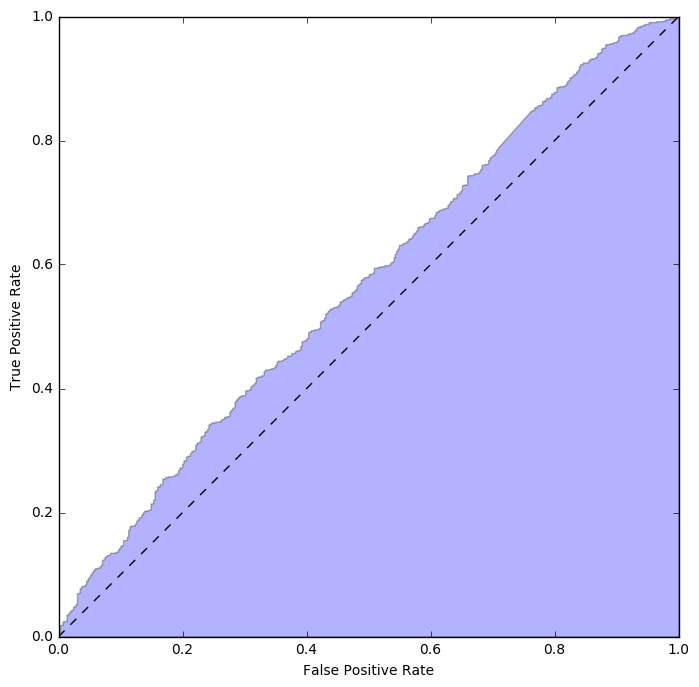

In [82]:
from sklearn.metrics import roc_curve
def classify(X, Y, test_size, C):
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=0.3, random_state=42)
    Y_test_prob = LogisticRegression().fit(X_train, Y_train,C).predict_proba(X_test)
    print len(Y_test_prob)
    print len(Y_test)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)
    roc_auc = auroc(Y_test_prob,Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    plt.figure(figsize=(8, 8))
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [83]:
test_users = df_users_ex["uid"].values
ix2 = np.in1d(users, test_users).reshape(users.shape)
X = X_dataset[np.where(ix2)]
X2 = X.tocsc()[:, features_counts > 100].toarray()

submission = LogisticRegression().fit(X1, Y, C[index]).predict_proba(X2)

10


In [86]:
df_users_test = pd.read_csv("test_submition.csv", sep=",", header=0)
test_users = df_users_test["uid"].values
output = pd.DataFrame()
output["uid"] = test_users
output["cls"] = submission
output.to_csv("Submission.csv",index = False)